In [1]:
import numpy as np
import pandas as pd
import torch
from scipy.linalg import toeplitz
from scipy.stats import norm

import matplotlib.pyplot as plt
from tableone import TableOne
from sksurv.nonparametric import kaplan_meier_estimator

from utils import data_processing, visualization
from utils.simulations import *
from execute import surv_hivae
#from utils.metrics import log_rank, cox_estimation

In [55]:
n_samples = 2000
n_features_bytype = 4
n_features_multiplier = 3 

In [56]:
beta_features = np.concatenate([weights_sparse_exp(n_features_bytype,3),weights_sparse_exp(n_features_bytype,3),
                       weights_sparse_exp(n_features_bytype,3)])
treatment_effect = 0

In [57]:
control, treated, types = simulation(beta_features, treatment_effect , n_samples,surv_type = "surv_weibull")
control = control.drop(columns='treatment')
treated = treated.drop(columns='treatment')

In [58]:
control.head()

,0,1,2,3,4,5,6,7,8,9,10,11,time,censor
0,0.294620,-0.454517,-3.309335,-2.479098,1.459420,2.293280,0.555385,1.291890,1.0,1.0,1.0,0.0,0.481217,0
1,0.583801,-0.203573,-0.759703,-0.218896,0.316379,0.202498,0.909899,0.209986,0.0,0.0,1.0,1.0,0.166368,0
2,0.961690,0.516959,1.325909,0.998877,1.670138,1.271723,0.327010,1.012246,1.0,1.0,1.0,1.0,0.006272,0
5,-0.043604,-0.157901,-0.063841,-0.187395,0.268730,0.547591,0.851300,0.869805,0.0,0.0,0.0,0.0,0.313313,0
6,0.759202,0.072134,-0.231748,-0.498316,0.264136,0.804601,1.644238,0.125270,0.0,0.0,0.0,0.0,0.039479,0


In [59]:
print(np.mean(control['censor']),np.mean(treated['censor']))

0.15192507804370448 0.15495668912415783


In [60]:
print(control.shape,treated.shape)

(961, 14) (1039, 14)


In [61]:
dataset_name = "Simulations"
data_file_control= "./dataset/" + dataset_name + "/data_control.csv"
feat_types_file_control = "./dataset/" + dataset_name + "/data_types_control.csv"
data_file_treated= "./dataset/" + dataset_name + "/data_treated.csv"
feat_types_file_treated= "./dataset/" + dataset_name + "/data_types_treated.csv"

# If the dataset has no missing data, leave the "miss_file" variable empty
miss_file = "dataset/" + dataset_name + "/Missing.csv"
true_miss_file = None

In [62]:
control.to_csv(data_file_control,index=False , header=False)
types.to_csv(feat_types_file_control)
treated.to_csv(data_file_treated,index=False , header=False)
types.to_csv(feat_types_file_treated)

## Compute expected power / level via Schoenfeld formula

$$D = \frac{(\Phi^{-1}(\beta)+\Phi^{-1}(1-\alpha))^2}{P_{cont}(1 - P_{cont}) log^2(\Delta)}$$
where 
- $D$ is the number of deaths
- $\alpha$ is the level
- $\beta$ is the power
- $P_{cont}$ is the proportion of patients in the control arm
- $\Delta$ is the hazard ratio

D

In [63]:
data = pd.concat([control,treated],ignore_index=True)

data['censor']
D = n_samples - np.sum(data['censor'])
print(D)

1693


In [64]:
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,time,censor
0,0.294620,-0.454517,-3.309335,-2.479098,1.459420,2.293280,0.555385,1.291890,1.0,1.0,1.0,0.0,0.481217,0
1,0.583801,-0.203573,-0.759703,-0.218896,0.316379,0.202498,0.909899,0.209986,0.0,0.0,1.0,1.0,0.166368,0
2,0.961690,0.516959,1.325909,0.998877,1.670138,1.271723,0.327010,1.012246,1.0,1.0,1.0,1.0,0.006272,0
3,-0.043604,-0.157901,-0.063841,-0.187395,0.268730,0.547591,0.851300,0.869805,0.0,0.0,0.0,0.0,0.313313,0
4,0.759202,0.072134,-0.231748,-0.498316,0.264136,0.804601,1.644238,0.125270,0.0,0.0,0.0,0.0,0.039479,0


In [65]:
alpha = 0.05
p_treated = treated.shape[0] / n_samples
treatment_effect = 0.5
expected_power = norm.cdf(np.sqrt( D * p_treated * (1 - p_treated) * (treatment_effect)**2 ) - norm.ppf(1 - alpha/2))

In [66]:
expected_power

np.float64(1.0)

## Replication

In [67]:
n_generated_dataset = 50
dataset_name = "Simulations"

In [68]:
alphas = np.arange(0,1.5,0.5)

## Independent

In [69]:
M = 500
log_p_value = []
log_p_value_gen = []
simu_num = []
treat_coef = []
D = []
for t in alphas:
    treatment_effect = t
    for m in np.arange(M):
        if m % 10 == 0:
            print(m)
        control, treated = simulation(beta_features, treatment_effect , n_samples,surv_type = "surv_weibull", data_types_create=False)
        
        control = control.drop(columns='treatment')
        treated = treated.drop(columns='treatment')
        D.append(control['censor'].sum()+treated['censor'].sum())
        
        data_file_control= "./dataset/" + dataset_name + "/data_control_gen" + str(m) +".csv"
        data_file_treated= "./dataset/" + dataset_name + "/data_treated_gen" + str(m) +".csv"
        
        
        control.to_csv(data_file_control,index=False , header=False)
        treated.to_csv(data_file_treated,index=False , header=False)
        

        p_value_init = compute_logrank_test(control, treated)
    
        log_p_value.append(p_value_init)
        simu_num.append(m)
        treat_coef.append(treatment_effect)


0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490


In [70]:

results = pd.DataFrame({'XP_num' : simu_num, "log_pvalue_init" : log_p_value, "treat_coef" : treat_coef, 'D' : D})
results["reject_H0_init"] = results['log_pvalue_init'] > -np.log(0.05)

In [71]:
results.head()

,XP_num,log_pvalue_init,treat_coef,D,reject_H0_init
0,0,0.139984,0.0,303,False
1,1,0.626276,0.0,311,False
2,2,0.219237,0.0,328,False
3,3,0.268989,0.0,319,False
4,4,0.069384,0.0,296,False


In [72]:
results.groupby("treat_coef").mean()["D"].to_numpy()

array([308.034, 352.496, 407.5  ])

In [73]:
alpha = 0.05
p_treated = 0.5
expected_power = []
for j in np.arange(alphas.shape[0]):
    treatment_effect = alphas[j]
    D = results.groupby("treat_coef").mean()["D"].to_numpy()[j]
    expected_power.append(norm.cdf(np.sqrt( D / 2 * p_treated * (1 - p_treated) * (treatment_effect)**2 ) - norm.ppf(1 - alpha/2)))

In [74]:
results[results["reject_H0_init"] ==  False].groupby(["treat_coef"]).mean()

,XP_num,log_pvalue_init,D,reject_H0_init
treat_coef,,,,
0.0,249.867368,0.834730,307.915789,0.0
0.5,248.961165,1.886818,353.349515,0.0
1.0,288.000000,2.940432,390.000000,0.0


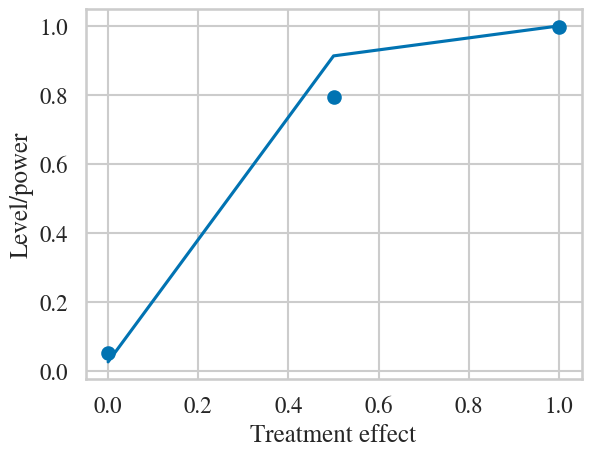

In [75]:
puiss_init = results.groupby("treat_coef").mean()["reject_H0_init"].to_numpy()
plt.scatter(alphas,puiss_init,label = "All init.")
plt.plot(alphas,expected_power,label = "Expected level/power")
plt.xlabel("Treatment effect")
plt.ylabel("Level/power")
plt.savefig("./dataset/" + dataset_name + "/results_independent_n_samples_" + str(n_samples) + "n_features_bytype_" + str(n_features_bytype) + ".jpeg")

## TODO point size should be proportional to sample size

## Dependent

In [50]:
M = 100
log_p_value = []
log_p_value_gen = []
simu_num = []
treat_coef = []
for t in alphas:
    treatment_effect = t
    for m in np.arange(M):
        if m % 10 == 0:
            print(m)
        control, treated =  simulation(beta_features, treatment_effect , n_samples, independent = False, surv_type = "surv_weibull",
                                     n_features_multiplier = 3, nnz = 3 , p_treated = 0.5, a_T = 2, a_C = 1, lamb_C = 0.15, 
                                     data_types_create = False)
        control = control.drop(columns='treatment')
        treated = treated.drop(columns='treatment')
        
        data_file_control= "./dataset/" + dataset_name + "/data_control_gen" + str(m) +".csv"
        data_file_treated= "./dataset/" + dataset_name + "/data_treated_gen" + str(m) +".csv"
        
        
        control.to_csv(data_file_control,index=False , header=False)
        treated.to_csv(data_file_treated,index=False , header=False)
        
        df_init_treated = pd.DataFrame(data_init_treated.numpy(), columns=fnames)
        df_init_control = pd.DataFrame(data_init_control.numpy(), columns=fnames)
        
        T_surv = torch.Tensor(df_init_control.time)
        T_surv_norm = (T_surv - T_surv.min()) / (T_surv.max() - T_surv.min())
        n_intervals = 5
        T_intervals = torch.linspace(0., T_surv_norm.max(), n_intervals)
        T_intervals = torch.cat([T_intervals, torch.tensor([2 * T_intervals[-1] - T_intervals[-2]])])
        intervals = [(T_intervals[i].item(), T_intervals[i + 1].item()) for i in range(len(T_intervals) - 1)]
        
        p_value_init = compute_logrank_test(control, treated)
    
        
    
        # Load and transform control data
        data_init_control_encoded, feat_types_dict, miss_mask_control, true_miss_mask_control, _ = data_processing.read_data(data_file_control, 
                                                                                                                     feat_types_file_control, 
                                                                                                                     miss_file, true_miss_file)
        data_init_control = data_processing.discrete_variables_transformation(data_init_control_encoded, feat_types_dict)
        
        # Load and transform treated data
        data_init_treated_encoded, _, _, _, _ = data_processing.read_data(data_file_treated, feat_types_file_treated, 
                                                                 miss_file, true_miss_file)
        data_init_treated = data_processing.discrete_variables_transformation(data_init_treated_encoded, feat_types_dict)
    
        data_gen_control = surv_hivae.run((data_init_control_encoded, intervals), miss_mask_control, 
                                      true_miss_mask_control, feat_types_file_control, feat_types_dict, n_generated_dataset,verbose=False)
        
        for i in range(n_generated_dataset):
            df_gen_control = pd.DataFrame(data_gen_control[i].numpy(), columns=fnames)
            df_gen_control['treatment'] = 0
            log_p_value.append(p_value_init)
            simu_num.append(m)
            p_value_gen = compute_logrank_test(df_gen_control, treated)
            log_p_value_gen.append(p_value_gen)
            treat_coef.append(treatment_effect)

0
10
20
30
40
50
60
70
80
90
0
10
20
30
40
50
60
70
80
90
0
10
20
30
40
50
60
70
80
90


In [57]:

results = pd.DataFrame({'XP_num' : simu_num, "log_pvalue_init" : log_p_value, "log_pvalue_gen" : log_p_value_gen , "treat_coef" : treat_coef})
results["reject_H0_init"] = results['log_pvalue_init'] > -np.log(0.05)
results["reject_H0_gen"] = results['log_pvalue_gen'] > -np.log(0.05)

In [58]:
results.to_csv("./dataset/" + dataset_name + "results_n_samples_" + str(n_samples) + "n_features_bytype_" + str(n_features_bytype) + ".csv")

In [59]:
alpha = 0.05
p_treated = 0.5
expected_power = []
for treatment_effect in np.arange(0,1.5,0.01):
    expected_power.append(norm.cdf(np.sqrt( D * p_treated * (1 - p_treated) * (treatment_effect)**2 ) - norm.ppf(1 - alpha/2)))

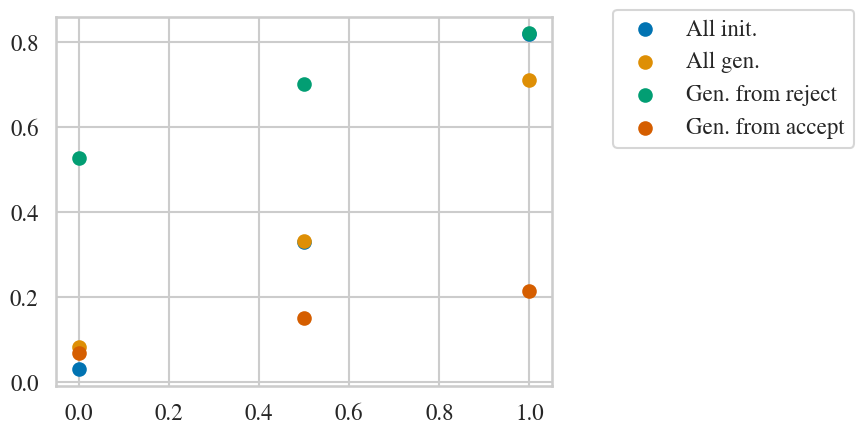

In [67]:
puiss_init = results.groupby("treat_coef").mean()["reject_H0_init"].to_numpy()
puiss_gen = results.groupby("treat_coef").mean()["reject_H0_gen"].to_numpy()
puiss_among_reject = results[results["reject_H0_init"] ==  True].groupby(["treat_coef"]).mean()["reject_H0_gen"].to_numpy()
puiss_among_accept = results[results["reject_H0_init"] ==  False].groupby(["treat_coef"]).mean()["reject_H0_gen"].to_numpy()
#puiss_among_accept = np.append(puiss_among_accept, np.nan)
plt.scatter(alphas,puiss_init,label = "All init.")
plt.scatter(alphas,puiss_gen,label = "All gen.")
plt.scatter(alphas,puiss_among_reject,label = "Gen. from reject")
plt.scatter(alphas,puiss_among_accept,label = "Gen. from accept")
#plt.plot(np.arange(0,1.5,0.01),expected_power,label = "Expected level/power")
plt.legend(bbox_to_anchor=(1.1, 1.05))